
# Backtesting Template

The purpose of this program is to provide a template with backtesting. The project requires different models  (and/or different model combinations) to create an asset management algorithm.



# 1. Read input files

In [23]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd


adjClose = pd.read_csv("MMF1921_AssetPrices_3.csv", index_col=0)
factorRet = pd.read_csv("MMF1921_FactorReturns_3.csv", index_col=0)

In [24]:
adjClose.index = pd.to_datetime(adjClose.index)
factorRet.index = pd.to_datetime(factorRet.index)

In [25]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months)
investPeriod = 6

factorRet = factorRet

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF']


In [26]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [27]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [28]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

           OLS portfolio  FF portfolio  LASSO portfolio  BSS portfolio
Period_0        0.297599      0.251174         0.211720       0.319987
Period_1        0.292179      0.246205         0.188978       0.312719
Period_2        0.292344      0.245658         0.182723       0.311249
Period_3        0.289535      0.242296         0.212778       0.306447
Period_4        0.282495      0.237413         0.204038       0.297377
Period_5        0.283742      0.237515         0.225823       0.296473
Period_6        0.281831      0.234938         0.210453       0.293576
Period_7        0.284614      0.236457         0.239190       0.295392
Period_8        0.316402      0.259211         0.266148       0.325195
Period_9        0.349930      0.292744         0.304149       0.355722
Period_10       0.351250      0.295612         0.300857       0.356591
Period_11       0.354704      0.300047         0.315671       0.359842
Period_12       0.357944      0.304008         0.320191       0.363056
Period

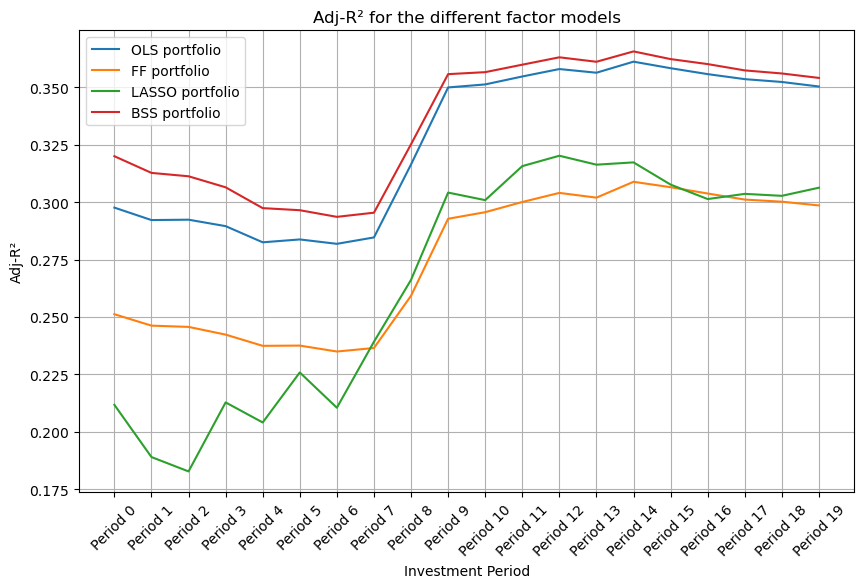

In [29]:
FMList = [OLS, FF, LASSO, BSS]

NoModels = len(FMList)

#Tags for the portfolios under the different factor models
tags = ['OLS portfolio', 'FF portfolio', 'LASSO portfolio', 'BSS portfolio']

# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

#End of the first investment period
testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

# Number of assets
n  = len(tickers)

# Preallocate storage for average adj-R²
adjR2 = {i: np.zeros(NoPeriods) for i in range(len(FMList))}

for t in range(NoPeriods):
    # 1) Subset your calibration window
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    # 2) Call each factor model, grab its adj-R² vector and store the mean
    for i, model in enumerate(FMList):
        # model should return (mu, Q, adj_vec)
        _, _, adj_vec = model(periodReturns, periodFactRet)
        adjR2[i][t] = adj_vec.mean()

   
    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

# 4) Build the DataFrame
adjR2_df = pd.DataFrame(
    { tags[i]: adjR2[i] for i in range(len(FMList)) },
    index=[f"Period_{t}" for t in range(NoPeriods)]
)

print(adjR2_df)

# 5) Plot the adj-R²
plt.figure(figsize=(10, 6))
plt.plot(adjR2_df)
plt.title("Adj-R² for the different factor models")
plt.xlabel("Investment Period")
plt.ylabel("Adj-R²")
# set tickers to be just the period number
plt.xticks(range(NoPeriods), [f"Period {t}" for t in range(NoPeriods)], rotation=45)
plt.legend(tags)
plt.grid()
plt.show()
# save to image folder with name adjR2 dataset 3

# plt.savefig("./images/adjR2_dataset_1.png")
# plt.close()

In [30]:
import math, time
import numpy as np
import pandas as pd

# 0) Instantiate your strategies and tags
Strategy_lst = [
    equal_weight(),
    HistoricalMeanVarianceOptimization(NumObs=60),
    OLS_MVO(NumObs=60),
    LASSO_MVO(NumObs=60),
    FactorRiskParity(NumObs=60, c=1.0),
    OLS_PCA_MVO(NumObs=60, n_pca=5),
    EnsembleFactor_MVO(NumObs=60),
    EnsembleFactor_RiskParity(NumObs=60, c=1.0)
]
tags = [
    "EqualWeight",
    "HistMVO",
    "OLS_MVO",
    "LASSO_MVO",
    "FactorRP",
    "OLS_PCA_MVO",
    "Ensemble_MVO",
    "Ensemble_RP"
]
NoModels = len(Strategy_lst)

# 2) Initialize your dates
testStart = returns.index[0] + pd.offsets.DateOffset(years=5)
testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
calEnd    = testStart - pd.offsets.DateOffset(days=1)
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)
start_time = time.time()
# --- 1) Preallocate storage ---
n = len(tickers)
currentVal = {tag: np.zeros(NoPeriods)    for tag in tags}
x0         = {tag: np.zeros(n)           for tag in tags}  # previous weights
turnover   = {tag: np.zeros(NoPeriods)   for tag in tags}
NoShares   = {tag: None                  for tag in tags}
portfValue = {tag: []                    for tag in tags}



# 3) Main loop
for t in range(NoPeriods):
    # subset calibration window
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    # get prices
    currentPrices = adjClose[
        (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index) &
        (adjClose.index <= calEnd)
    ]
    periodPrices = adjClose[
        (testStart <= adjClose.index) &
        (adjClose.index <= testEnd)
    ]
    assert len(currentPrices) == 1
    assert len(periodPrices) == investPeriod

    # initialize or update portfolio value
    if t == 0:
        for tag in tags:
            currentVal[tag][0] = initialVal
    else:
        for tag in tags:
            currentVal[tag][t] = (currentPrices @ NoShares[tag]).item()
            # compute previous weights
            x0[tag] = (currentPrices.values.flatten() * NoShares[tag]) / currentVal[tag][t]

    # compute each strategy’s weights, turnover, shares, and values
    for strat, tag in zip(Strategy_lst, tags):
        # 1) get new weights
        x_w = strat.execute_strategy(periodReturns, periodFactRet)  # shape (n,)

        # 2) compute turnover using x0
        if t == 0:
            turnover[tag][t] = 0.0
        else:
            turnover[tag][t] = np.sum(np.abs(x_w - x0[tag]))

        # 3) compute number of shares
        NoShares[tag] = x_w * currentVal[tag][t] / currentPrices.values.flatten()

        # 4) record this period’s portfolio values
        portfValue[tag].append(periodPrices @ NoShares[tag])

    # advance windows
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

# 4) After loop: stitch together results
for tag in tags:
    portfValue[tag] = pd.concat(portfValue[tag], axis=0)

# Portfolio value DataFrame
portfValue_df = pd.concat(
    [portfValue[tag] for tag in tags],
    axis=1,
    keys=tags
)

# Turnover DataFrame
turnover_df = pd.DataFrame(
    turnover,
    index=[f"Period_{t}" for t in range(NoPeriods)]
)

end_time = time.time()

# Results:
print(portfValue_df.head())
print(turnover_df.head())


              EqualWeight        HistMVO        OLS_MVO      LASSO_MVO  \
Date                                                                     
2005-01-31   97386.764685   94667.833473   94882.971828   94108.237121   
2005-02-28  100973.479967  100143.770845   99460.686108   98523.945647   
2005-03-31   99119.535536   96455.711515   95943.364354   95209.705807   
2005-04-30   96574.996110   98362.031846   98936.793191   98306.844398   
2005-05-31   99638.498330  101355.684084  102287.336181  101675.318989   

                 FactorRP    OLS_PCA_MVO   Ensemble_MVO    Ensemble_RP  
Date                                                                    
2005-01-31   96256.527723   94875.004352   94690.356471   96164.241082  
2005-02-28   99901.608970   99595.811507   99188.995029   99770.054315  
2005-03-31   97577.399806   96047.529631   95686.602576   97453.139948  
2005-04-30   97384.652102   98930.565907   98737.771969   97250.943421  
2005-05-31  100520.319817  102241.125040  1

# 3. Results

In [31]:
#--------------------------------------------------------------------------  
# 3.1 Calculate avg return, std, Sharpe ratio, avg turnover, and max drawdown  
#--------------------------------------------------------------------------  

# 1) Calculate the observed portfolio returns (one‐period pct change)  
portfRets = portfValue_df.pct_change().iloc[1:]  

# 2) Align risk‐free series to the same dates  
rf = riskFree.loc[portfRets.index]  

# 3) Compute excess returns for each strategy  
portfExRets = portfRets.sub(rf, axis=0)  

# 4) Sharpe ratio per strategy  
SR = ((portfExRets + 1)
      .apply(gmean, axis=0)
      .subtract(1)) \
     .div(portfExRets.std())  

# 5) Average turnover per strategy  
avgTurnover = turnover_df.mean()  

# 6) Maximum drawdown per strategy  
#    rolling peak, then drawdown = (peak - value)/peak  
rolling_peak = portfValue_df.cummax()  
drawdowns    = (rolling_peak - portfValue_df) / rolling_peak  
maxDrawdown  = drawdowns.max()  

# 7) Combine into a single table  
metrics_df = pd.DataFrame({  
    'Sharpe':      SR,  
    'AvgTurnover': avgTurnover,  
    'MaxDrawdown': maxDrawdown  
})  

print(f"Elapsed time: {end_time - start_time:.2f} seconds\n")  
print(metrics_df)  

Elapsed time: 51.96 seconds

                Sharpe  AvgTurnover  MaxDrawdown
EqualWeight   0.181488     0.131019     0.460508
HistMVO       0.170888     0.460799     0.353035
OLS_MVO       0.157337     0.398609     0.352196
LASSO_MVO     0.150151     0.536836     0.371266
FactorRP      0.180999     0.141170     0.425170
OLS_PCA_MVO   0.158083     0.399817     0.358283
Ensemble_MVO  0.152710     0.426403     0.361115
Ensemble_RP   0.180943     0.146669     0.426205


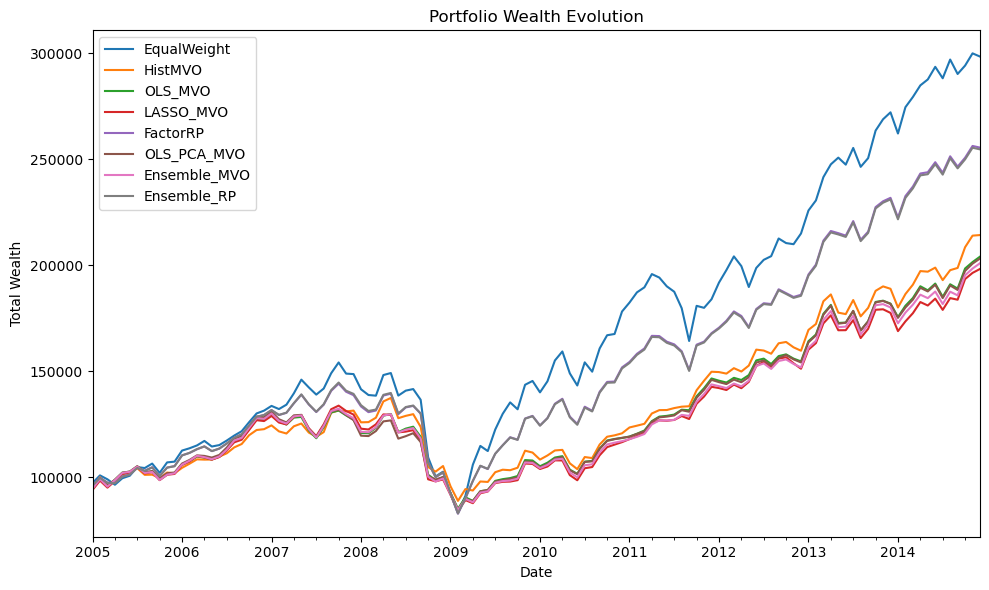

In [32]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Plot the out‐of‐sample portfolio wealth for all strategies
fig, ax = plt.subplots(figsize=(10, 6))
portfValue_df.plot(ax=ax,
                   title='Portfolio Wealth Evolution',
                   ylabel='Total Wealth')
ax.set_xlabel('Date')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("images/wealth_evolution.svg")

In [33]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
weights[(weights > 0).any(axis=1)].T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

AttributeError: 'dict' object has no attribute 'plot'

<Figure size 640x480 with 0 Axes>